In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np

# Set dark theme
plt.style.use("dark_background")

# Custom color palette
COLORS = {
    "price": "#00FFFF",  # Cyan
    "change": "#FF69B4",  # Hot Pink
    "highlight": "#FFD700",  # Gold
    "grid": "#2A2A2A",  # Dark Gray
    "text": "#FFFFFF",  # White
}

# Load the data
with open("db.json", "r") as f:
    data = json.load(f)

In [2]:
all_txs = []
for token in data["tokens"]:
    for tx in token["txs"]:
        tx["token_address"] = token["address"]
        tx["token_name"] = token["info"]["name"]
        tx["token_symbol"] = token["info"]["symbol"]
        all_txs.append(tx)

df = pd.DataFrame(all_txs)
# Convert newPrice to float
df["newPrice"] = df["newPrice"].astype(float)

# Get token trade counts and filter for tokens with mostly trades above 0.1 SOL
token_trade_counts = df.groupby("token_address").size()
token_avg_prices = df.groupby("token_address")["newPrice"].mean()
active_tokens = token_trade_counts[
    (token_trade_counts > 60) & (token_avg_prices > 0.1)
].index.tolist()

if not active_tokens:
    print("No tokens found with more than 60 trades and average price above 0.1 SOL!")
    exit()


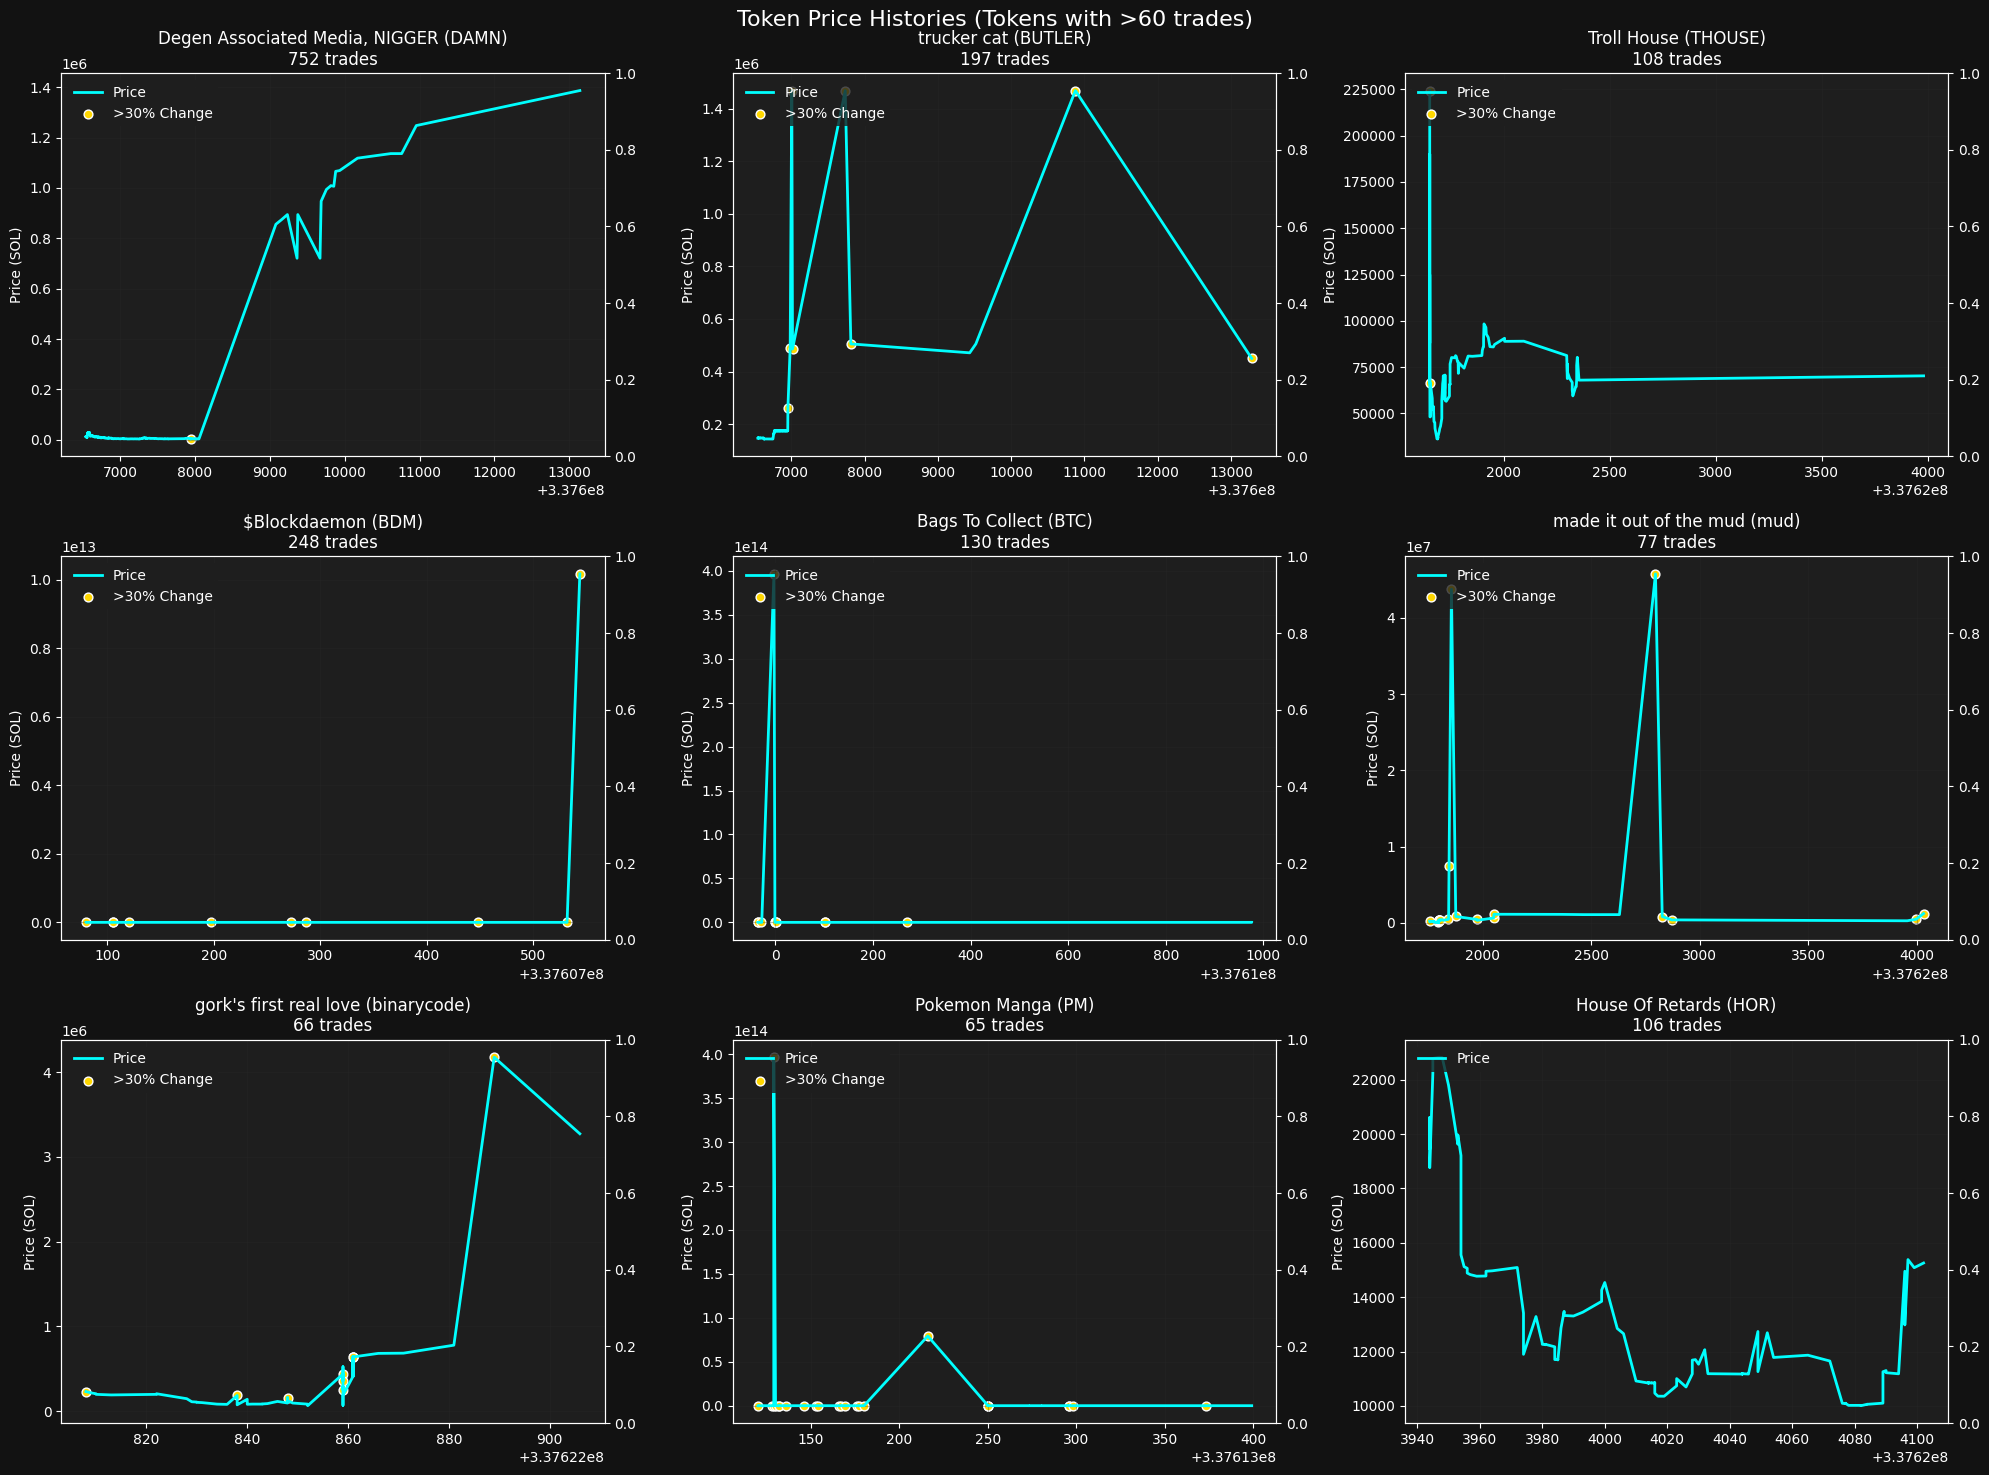

In [17]:

fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle(
    "Token Price Histories (Tokens with >60 trades)", fontsize=16, color=COLORS["text"]
)
# Set figure background color
fig.patch.set_facecolor("#121212")

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Select 9 random tokens
selected_tokens = random.sample(active_tokens, min(9, len(active_tokens)))

for idx, (ax, random_token) in enumerate(zip(axes, selected_tokens)):
    token_name = df[df["token_address"] == random_token]["token_name"].iloc[0]
    token_symbol = df[df["token_address"] == random_token]["token_symbol"].iloc[0]
    trade_count = token_trade_counts[random_token]

    # Filter data for random token
    token_data = df[df["token_address"] == random_token].sort_values("slot")

    # Create twin axes for price and percentage change
    ax2 = ax.twinx()

    # Set subplot background color
    ax.set_facecolor("#1E1E1E")
    ax2.set_facecolor("#1E1E1E")

    # Plot price changes
    ax.plot(
        token_data["slot"],
        token_data["newPrice"].astype(float),
        color=COLORS["price"],
        label="Price",
        linewidth=2,
    )
    ax.set_title(
        f"{token_name} ({token_symbol})\n{trade_count} trades", color=COLORS["text"]
    )
    ax.set_ylabel("Price (SOL)", color=COLORS["text"])
    ax.grid(True, color=COLORS["grid"], alpha=0.3)
    ax.tick_params(axis="y", colors=COLORS["text"])
    ax.tick_params(axis="x", colors=COLORS["text"])

    # Highlight significant changes (>30%) on the price plot with smaller dots
    significant_changes = token_data[
        (abs(token_data["priceChangePercent"]) > 30)
        & (token_data["newPrice"].astype(float) > 0.1)
    ]
    if not significant_changes.empty:
        ax.scatter(
            significant_changes["slot"],
            significant_changes["newPrice"].astype(float),
            color=COLORS["highlight"],
            s=40,  # Smaller dot size
            marker="o",
            label=">30% Change",
            edgecolors="white",
            linewidth=1,
        )

    # Combine legends
    lines1, labels1 = ax.get_legend_handles_labels()
    ax.legend(
        lines1,
        labels1,
        loc="upper left",
        facecolor="#1E1E1E",
        edgecolor="none",
        labelcolor=COLORS["text"],
    )

plt.tight_layout()
plt.show()


In [4]:
import tensorflow as tf

In [10]:
import json
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

SEQUENCE_LENGTH = 10
FEATURES = ['isBuy', 'solAmount', 'tokenAmount', 'priceChangePercent', 'realSolReserves', 'realTokenReserves']

def load_data(path='data.json'):
    with open(path) as f:
        data = json.load(f)['tokens']

    X = []
    y = []

    for token in data:
        txs = token['txs']
        if len(txs) < SEQUENCE_LENGTH:
            continue

        # Normalize and extract features
        sequence = []
        for tx in txs[:SEQUENCE_LENGTH]:
            f = [
                1 if tx['isBuy'] else 0,
                float(tx['solAmount']),
                float(tx['tokenAmount']),
                float(tx['priceChangePercent']),
                float(tx['realSolReserves']),
                float(tx['realTokenReserves']),
            ]
            sequence.append(f)

        # Normalize per sequence (min-max normalization)
        arr = np.array(sequence)
        arr_min = arr.min(axis=0)
        arr_max = arr.max(axis=0)
        arr_norm = (arr - arr_min) / (arr_max - arr_min + 1e-9)

        X.append(arr_norm)
        y.append(token.get('label', 0))  # Default 0 if no label

    return np.array(X), np.array(y)

def build_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')  # Rug pull risk % (0 to 1)
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def main():
    X, y = load_data('db.json')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = build_model((SEQUENCE_LENGTH, len(FEATURES)))
    model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test))

    model.save('rugpull_model.h5')
    print("Model saved to rugpull_model.h5")

if __name__ == '__main__':
    main()


I0000 00:00:1746338305.061691 2347441 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1746338305.062381 2347441 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/ujjujjuj/.pyenv/versions/3.11.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


2025-05-04 11:28:26.135769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9469 - loss: 0.4083 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 4.2842e-04
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 5.7479e-04 - val_accuracy: 1.0000 - val_loss: 2.8227e-04
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 4.6204e-04 - val_accuracy: 1.0000 - val_loss: 1.9675e-04
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 3.1184e-04 - val_accuracy: 1.0000 - val_loss: 1.5217e-04
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 2.5156e-04 - val_accuracy: 1.0000 - val_loss: 1.1784e-04
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 1.9569e-04 - val_accuracy: 1.0000 - val_loss: 9.5022e-05
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 

Model saved to rugpull_model.h5
